## 0. Import modules

In [1]:
from unityagents import UnityEnvironment
import torch
import numpy as np
import pandas as pd
from collections import deque
import sys
import matplotlib.pyplot as plt
%matplotlib inline

# Agent module
from Navigation_agent import Agent                  

## 1. Start the environment

In [2]:
env_path = "Banana_Linux/Banana.x86_64"
env = UnityEnvironment(file_name = env_path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Examine the state and action space

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


## 3. Define training functions

In [5]:
#Define training function
def dqn(agent, file, n_episodes=1000, eps_start=1.0, eps_end=0.05, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    print('Training started!!!!!!')
    scores = []                        # list containing scores from each episode    
    scores_window = deque(maxlen=100)  # last 100 scores
    previous_mean = -np.inf            # initialize mean over last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        while True:
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0] 
            done = env_info.local_done[0]   
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        #Saves weights with the best average score over 100 consecutive episodes
        if (np.mean(scores_window) >= previous_mean):
            previous_mean = np.mean(scores_window)
            torch.save(agent.qnetwork_local.state_dict(), file)
    return scores

In [6]:
#Define the function that shows training results
def show_results(scores):
    moving_average = pd.Series(scores).rolling(100).mean()
    episodes_greater_than_13 = np.where(moving_average>13)[0]  
    if episodes_greater_than_13.size > 0:
        end =episodes_greater_than_13[0]
        start = end - 100 + 1
        print('\nEnvironment solved in {:d} episodes!\tAverage score from episode {} to episode {}: {:.2f}'.\
              format(end+1, start+1, end+1, moving_average[end])) #Remember that episodes start from 1, not zero
    else:
        print('Neural net could not solve environment in {:d} episodes. Max average score was {:.2f}'.\
              format(len(scores), moving_average.max()))

    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores))+1, scores, label='Scores')
    plt.plot(np.arange(len(scores))+1, moving_average, label='Moving average 100 episodes')
    plt.title('Training evolution')
    plt.ylabel('Score and moving average 100 episodes')
    plt.xlabel('Episode #')
    plt.legend()
    plt.show()

## 4. Define the function that drives the behavior of the trained agent

In [7]:
#Define the function that shows trained model in action
def show_trained_agent(agent, file, n_episodes_trained=500):
    agent.qnetwork_local.load_state_dict(torch.load(file)) #load the weights from file
    scores_trained = []
    print('Observing performance of trained agent...')
    for i_episode in range(1, n_episodes_trained + 1):
        env_info = env.reset(train_mode=False)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        while True:
            action = agent.act(state=state, eps=0)
            env_info = env.step(action)[brain_name]
            state = env_info.vector_observations[0]        # Update state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            score += reward                                # update the score  
            if done:
                break 
        scores_trained.append(score)
        print('\rEpisode {:d}/{:d}\tScore: {:.2f}'.format(i_episode, n_episodes_trained, score), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {:d}/{:d}\tScore: {:.2f}'.format(i_episode, n_episodes_trained, score))
    print('Average score over {:d} episodes: {:.2f}'.format(n_episodes_trained, np.mean(scores_trained)))
    return scores_trained

In [8]:
#Define the function that plots the scores of the trained agent
def show_results_trained(scores_trained):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores_trained))+1, scores_trained)
    plt.title('Trained agent scores')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show() 

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.hist(scores_trained)
    plt.title('Trained agent score distribution')
    plt.ylabel('Frequency')
    plt.xlabel('Score')
    plt.show()

## 5. Train a vanilla agent and check its performance

Training started!!!!!!
Episode 100	Average Score: 0.64
Episode 200	Average Score: 3.78
Episode 300	Average Score: 8.12
Episode 400	Average Score: 10.87
Episode 500	Average Score: 12.55
Episode 600	Average Score: 13.77
Episode 700	Average Score: 14.31
Episode 800	Average Score: 14.26
Episode 900	Average Score: 14.18
Episode 1000	Average Score: 14.64

Environment solved in 515 episodes!	Average score from episode 416 to episode 515: 13.05


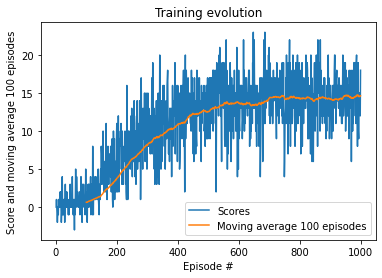

In [9]:
#Define the agent
agent = Agent(state_size, action_size, double_q=False)

#Train the agent
scores = dqn(agent, 'checkpoint.pth')

#Show training results
show_results(scores)

Observing performance of trained agent...
Episode 100/500	Score: 10.00
Episode 200/500	Score: 18.00
Episode 300/500	Score: 19.00
Episode 400/500	Score: 22.00
Episode 500/500	Score: 17.00
Average score over 500 episodes: 15.88


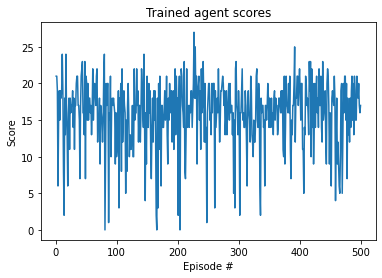

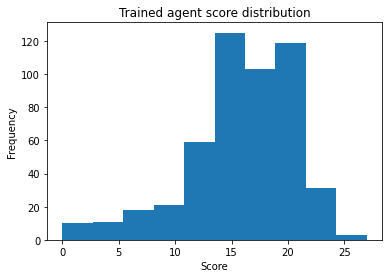

Score standard deviation: 4.69


In [10]:
#Run some episodes using the trained model
scores_trained = show_trained_agent(agent, 'checkpoint.pth')

#Plot the scores of the trained agent
show_results_trained(scores_trained)

print('Score standard deviation: {:.2f}'.format(np.std(scores_trained)))

## 6. Train a double-Q agent and check its performance

In [11]:
#Clear GPU memory before training
torch.cuda.empty_cache()

Training started!!!!!!
Episode 100	Average Score: 0.45
Episode 200	Average Score: 3.92
Episode 300	Average Score: 7.47
Episode 400	Average Score: 10.26
Episode 500	Average Score: 12.65
Episode 600	Average Score: 14.53
Episode 700	Average Score: 14.39
Episode 800	Average Score: 15.12
Episode 900	Average Score: 14.86
Episode 1000	Average Score: 15.32

Environment solved in 518 episodes!	Average score from episode 419 to episode 518: 13.04


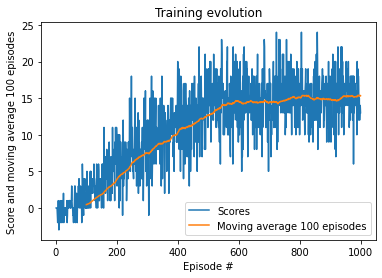

In [12]:
#Define the agent
agent_dq = Agent(state_size, action_size, double_q=True)

#Train the agent
scores_dq = dqn(agent_dq, 'checkpoint_dq.pth')

#Show training results
show_results(scores_dq)

Observing performance of trained agent...
Episode 100/500	Score: 19.00
Episode 200/500	Score: 20.00
Episode 300/500	Score: 21.00
Episode 400/500	Score: 17.00
Episode 500/500	Score: 16.00
Average score over 500 episodes: 15.92


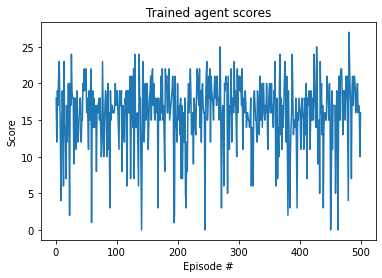

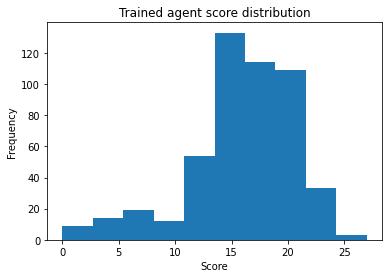

Score standard deviation: 4.70


In [13]:
#Run some episodes using the trained model
scores_trained_dq = show_trained_agent(agent_dq, 'checkpoint_dq.pth')

#Plot the scores of the trained agent
show_results_trained(scores_trained_dq)

print('Score standard deviation: {:.2f}'.format(np.std(scores_trained_dq)))

## 7. Compare training performance of vanilla agent and double-Q agent

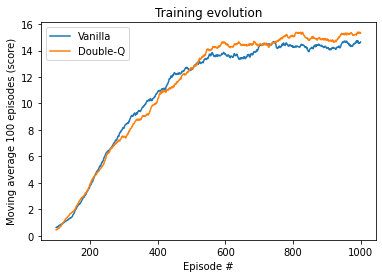

In [14]:
vanilla = pd.Series(scores).rolling(100).mean()
double_Q = pd.Series(scores_dq).rolling(100).mean()

plt.plot(np.arange(len(vanilla))+1, vanilla, label='Vanilla')
plt.plot(np.arange(len(double_Q))+1, double_Q, label='Double-Q')
plt.title('Training evolution')
plt.ylabel('Moving average 100 episodes (score)')
plt.xlabel('Episode #')
plt.legend()
plt.show()

In [15]:
#Close environment
env.close()